In [1]:
# Step 1: Environment Setup and Library Imports

# Core libraries for data handling and processing
import os
import numpy as np
import pandas as pd
from tqdm import tqdm # For creating smart progress bars

# Audio processing library
import librosa
import librosa.display

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for data splitting and encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras for building and training the deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input ,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

2025-06-25 16:37:00.523656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750869420.677595      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750869420.722901      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!
TensorFlow version: 2.18.0


In [2]:
# Step 2: Define Data Paths and Emotion Mapping

# Define the root directory for the audio datasets in Kaggle
# These paths were verified in our very first successful steps of the previous project iteration.
audio_data_root = '/kaggle/input/emotion-classification-mars/'
audio_speech_path = os.path.join(audio_data_root, 'Audio_Speech_Actors_01-24')
audio_song_path = os.path.join(audio_data_root, 'Audio_Song_Actors_01-24')

# Emotion mapping for RAVDESS dataset (verified from previous steps)
# This dictionary maps the numerical emotion codes in filenames to human-readable labels.
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

print("Data paths and emotion mapping defined:")
print(f"Speech data path: {audio_speech_path}")
print(f"Song data path: {audio_song_path}")
print(f"Emotion mapping: {emotion_mapping}")


# Verify the Exact Dataset Folder Names

# Let's list the contents of the /kaggle/input/ directory to see the actual folder names.
# This helps us avoid "File Not Found" errors.
print("Contents of /kaggle/input/:")
print(os.listdir('/kaggle/input/'))


#  Verify Sub-folder Names

# Now that we've confirmed the 'audiodatasets' folder exists,
# let's look inside it to get the final folder names.
verified_path = '/kaggle/input/emotion-classification-mars'
print(f"Contents of {verified_path}:")
print(os.listdir(verified_path))

Data paths and emotion mapping defined:
Speech data path: /kaggle/input/emotion-classification-mars/Audio_Speech_Actors_01-24
Song data path: /kaggle/input/emotion-classification-mars/Audio_Song_Actors_01-24
Emotion mapping: {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
Contents of /kaggle/input/:
['emotion-classification-mars']
Contents of /kaggle/input/emotion-classification-mars:
['Audio_Song_Actors_01-24', 'Audio_Speech_Actors_01-24']


In [3]:
# Step 5: Define the Spectrogram Extraction Function

def extract_mel_spectrogram(file_path):
    """
    This function takes the path to an audio file, loads it,
    and converts it into a Mel-Spectrogram.
    
    To ensure all our "images" (spectrograms) are the same size for the model,
    we will pad or truncate them to a fixed length.
    """
    
    # Constants for spectrogram generation
    SAMPLE_RATE = 22050      # Standard sample rate for many audio tasks
    DURATION_SECONDS = 4     # We will use 4 seconds of audio from each file
    N_MELS = 128             # The number of Mel-frequency bins (height of the image)
    MAX_PAD_LEN = 174        # The fixed width of our spectrogram image
    
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION_SECONDS)

        # Pad the audio to ensure it's exactly 4 seconds long
        target_length = DURATION_SECONDS * SAMPLE_RATE
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
        
        # Generate the Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=N_MELS)
        
        # Convert power spectrogram to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Pad or truncate the spectrogram to the fixed width (MAX_PAD_LEN)
        if mel_spec_db.shape[1] < MAX_PAD_LEN:
            pad_width = MAX_PAD_LEN - mel_spec_db.shape[1]
            padded_spec = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            padded_spec = mel_spec_db[:, :MAX_PAD_LEN]
            
        return padded_spec
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print("Spectrogram extraction function 'extract_mel_spectrogram' has been defined.")

Spectrogram extraction function 'extract_mel_spectrogram' has been defined.


In [4]:
# Step 6: Load Datasets and Extract Mel-Spectrograms

# Lists to store our spectrograms and corresponding labels
all_spectrograms = []
all_labels = []

# --- Load Speech Data ---
print("\nLoading Speech Data...")
# Loop through each actor folder in the speech dataset path
for actor_dir in tqdm(sorted(os.listdir(audio_speech_path)), desc='Processing Speech Actors'):
    actor_full_path = os.path.join(audio_speech_path, actor_dir)
    
    # Ensure it's actually a directory
    if os.path.isdir(actor_full_path):
        # Loop through each audio file in the actor's directory
        for audio_file_name in os.listdir(actor_full_path):
            if audio_file_name.endswith('.wav'):
                file_full_path = os.path.join(actor_full_path, audio_file_name)
                
                # Extract spectrogram
                spectrogram = extract_mel_spectrogram(file_full_path)
                
                # If extraction was successful, append to our lists
                if spectrogram is not None:
                    all_spectrograms.append(spectrogram)
                    
                    # Extract emotion from filename using our predefined mapping
                    emotion_code = audio_file_name.split('-')[2] # Emotion code is the 3rd part
                    all_labels.append(emotion_mapping.get(emotion_code, 'unknown'))

# --- Load Song Data ---
print("\nLoading Song Data...")
# Repeat the process for song data
for actor_dir in tqdm(sorted(os.listdir(audio_song_path)), desc='Processing Song Actors'):
    actor_full_path = os.path.join(audio_song_path, actor_dir)
    
    if os.path.isdir(actor_full_path):
        for audio_file_name in os.listdir(actor_full_path):
            if audio_file_name.endswith('.wav'):
                file_full_path = os.path.join(actor_full_path, audio_file_name)
                
                spectrogram = extract_mel_spectrogram(file_full_path)
                
                if spectrogram is not None:
                    all_spectrograms.append(spectrogram)
                    
                    emotion_code = audio_file_name.split('-')[2]
                    all_labels.append(emotion_mapping.get(emotion_code, 'unknown'))

# Convert lists to NumPy arrays for efficient processing
X = np.array(all_spectrograms)
y = np.array(all_labels)

print(f"\nFinished loading all data.")
print(f"Total spectrograms loaded: {X.shape}")
print(f"Total labels loaded: {y.shape}")
print(f"Shape of a single spectrogram: {X[0].shape if len(X) > 0 else 'No data'}")


Loading Speech Data...


Processing Speech Actors: 100%|██████████| 24/24 [00:55<00:00,  2.30s/it]



Loading Song Data...


Processing Song Actors: 100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


Finished loading all data.
Total spectrograms loaded: (2452, 128, 174)
Total labels loaded: (2452,)
Shape of a single spectrogram: (128, 174)


In [5]:
# Step 7: Label Encoding and Data Shape Preparation

# Convert emotion labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Add a channel dimension to make spectrograms compatible with 2D CNN
# Shape changes from (2452, 128, 174) to (2452, 128, 174, 1)
X_reshaped = X[..., np.newaxis]

print("Label encoding completed:")
print(f"Emotion classes: {label_encoder.classes_}")
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Reshaped spectrograms shape: {X_reshaped.shape}")

# Show label distribution
from collections import Counter
label_distribution = Counter(y)
print(f"\nLabel distribution:")
for emotion, count in sorted(label_distribution.items()):
    print(f"  {emotion}: {count}")

Label encoding completed:
Emotion classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Encoded labels shape: (2452,)
Reshaped spectrograms shape: (2452, 128, 174, 1)

Label distribution:
  angry: 376
  calm: 376
  disgust: 192
  fearful: 376
  happy: 376
  neutral: 188
  sad: 376
  surprised: 192


In [6]:
# Step 8: Split Data into Training, Validation, and Test Sets

# First, we separate the data into a large chunk for training/validation (80%)
# and a final, untouched test set (20%).
# 'stratify=y_encoded' ensures that the proportion of each emotion is the same
# in both the 80% chunk and the 20% test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_reshaped, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Now, we split the 80% chunk into our final training set and a validation set.
# We take 20% of this chunk for validation, which corresponds to 16% of the original total.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.2,
    random_state=42, 
    stratify=y_train_val
)

print("Data splitting complete.")
print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Data splitting complete.
Training set shape: (1568, 128, 174, 1), Training labels shape: (1568,)
Validation set shape: (393, 128, 174, 1), Validation labels shape: (393,)
Test set shape: (491, 128, 174, 1), Test labels shape: (491,)


In [7]:
# Step 9: Extract Reference-Style Features with Advanced Preprocessing

def extract_advanced_mel_features(file_path, sr=22050, n_mels=77, max_pad_len=174):
    """
    Extract mel-spectrogram using reference approach but with advanced preprocessing
    Based on research showing 88.8% accuracy with 77 mel bands
    """
    try:
        # Load audio with 3 second duration (proven optimal from reference)
        audio, sample_rate = librosa.load(file_path, sr=sr, duration=3.0)
        
        # Advanced preprocessing: Pre-emphasis filter (from research papers)
        pre_emphasis = 0.97
        audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
        
        # Pad or truncate to consistent length
        target_length = sr * 3
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        # Extract mel-spectrogram with optimized parameters
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sample_rate, 
            n_mels=n_mels,  # 77 mel bands (proven from reference)
            n_fft=2048,     # Optimal FFT size
            hop_length=512, # Optimal hop length
            win_length=2048,# Window length
            window='hann'   # Hann window for better frequency resolution
        )
        
        # Convert to dB scale with better dynamic range
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
        
        # Normalize to [-1, 1] range for better training stability
        mel_spec_normalized = 2 * (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min()) - 1
        
        # Pad/truncate to fixed time dimension
        if mel_spec_normalized.shape[1] < max_pad_len:
            pad_width = max_pad_len - mel_spec_normalized.shape[1]
            mel_spec_normalized = np.pad(mel_spec_normalized, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_normalized = mel_spec_normalized[:, :max_pad_len]
        
        return mel_spec_normalized.T  # Shape: (174, 77) - transpose for CNN input
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test the advanced feature extraction
sample_file = '/kaggle/input/audiodatasets/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav'
sample_advanced_features = extract_advanced_mel_features(sample_file)

 

Error processing /kaggle/input/audiodatasets/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav: [Errno 2] No such file or directory: '/kaggle/input/audiodatasets/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav'


In [8]:
# Step 10: Load Complete Dataset with Advanced Features

print("=== LOADING COMPLETE DATASET WITH ADVANCED FEATURES ===")

# Lists to store features and labels
all_advanced_features = []
all_advanced_labels = []

# Load Speech Data with progress tracking
print("Loading Speech Data...")
speech_count = 0
for actor_dir in tqdm(sorted(os.listdir(audio_speech_path)), desc='Processing Speech Actors'):
    actor_full_path = os.path.join(audio_speech_path, actor_dir)
    
    if os.path.isdir(actor_full_path):
        for audio_file_name in os.listdir(actor_full_path):
            if audio_file_name.endswith('.wav'):
                file_full_path = os.path.join(actor_full_path, audio_file_name)
                
                # Extract advanced features
                features = extract_advanced_mel_features(file_full_path)
                
                if features is not None:
                    all_advanced_features.append(features)
                    
                    # Extract emotion from filename
                    emotion_code = audio_file_name.split('-')[2]
                    emotion = emotion_mapping.get(emotion_code, 'unknown')
                    all_advanced_labels.append(emotion)
                    speech_count += 1

# Load Song Data
print("Loading Song Data...")
song_count = 0
for actor_dir in tqdm(sorted(os.listdir(audio_song_path)), desc='Processing Song Actors'):
    actor_full_path = os.path.join(audio_song_path, actor_dir)
    
    if os.path.isdir(actor_full_path):
        for audio_file_name in os.listdir(actor_full_path):
            if audio_file_name.endswith('.wav'):
                file_full_path = os.path.join(actor_full_path, audio_file_name)
                
                # Extract advanced features
                features = extract_advanced_mel_features(file_full_path)
                
                if features is not None:
                    all_advanced_features.append(features)
                    
                    # Extract emotion from filename
                    emotion_code = audio_file_name.split('-')[2]
                    emotion = emotion_mapping.get(emotion_code, 'unknown')
                    all_advanced_labels.append(emotion)
                    song_count += 1

# Convert to numpy arrays
X_advanced = np.array(all_advanced_features)
y_advanced = np.array(all_advanced_labels)

print(f"\nDataset Loading Complete!")
print(f"Speech samples: {speech_count}")
print(f"Song samples: {song_count}")
print(f"Total samples: {X_advanced.shape[0]}")
print(f"Feature shape: {X_advanced.shape}")
print(f"Labels shape: {y_advanced.shape}")
print(f"Feature range: [{X_advanced.min():.3f}, {X_advanced.max():.3f}]")

=== LOADING COMPLETE DATASET WITH ADVANCED FEATURES ===
Loading Speech Data...


Processing Speech Actors: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Loading Song Data...


Processing Song Actors: 100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Dataset Loading Complete!
Speech samples: 1440
Song samples: 1012
Total samples: 2452
Feature shape: (2452, 174, 77)
Labels shape: (2452,)
Feature range: [-1.000, 1.000]


In [9]:
# Step 11: Prepare Data for Training

print("=== PREPARING DATA FOR TRAINING ===")

# Encode emotion labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_advanced)

# Add channel dimension for CNN input (2452, 174, 77) -> (2452, 174, 77, 1)
X_reshaped = X_advanced[..., np.newaxis]

print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Reshaped features shape: {X_reshaped.shape}")
print(f"Emotion classes: {label_encoder.classes_}")

# Split data with proper stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_reshaped, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_val
)

print(f"\nData splits:")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize data using training statistics only (no data leakage)
train_mean = X_train.mean()
train_std = X_train.std()

X_train_norm = (X_train - train_mean) / train_std
X_val_norm = (X_val - train_mean) / train_std
X_test_norm = (X_test - train_mean) / train_std

print(f"\nNormalization applied:")
print(f"Training mean: {X_train_norm.mean():.6f}, std: {X_train_norm.std():.6f}")
print(f"Validation mean: {X_val_norm.mean():.6f}")
print(f"Test mean: {X_test_norm.mean():.6f}")
print("✓ Data preparation complete - ready for model training")

=== PREPARING DATA FOR TRAINING ===
Encoded labels shape: (2452,)
Reshaped features shape: (2452, 174, 77, 1)
Emotion classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Data splits:
Training set: (1568, 174, 77, 1), (1568,)
Validation set: (393, 174, 77, 1), (393,)
Test set: (491, 174, 77, 1), (491,)

Normalization applied:
Training mean: -0.000000, std: 1.000000
Validation mean: 0.006212
Test mean: 0.012306
✓ Data preparation complete - ready for model training


In [12]:
# Step 12: CNN Architecture
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
print("=== IMPLEMENTING EXACT REFERENCE CNN ARCHITECTURE ===")

def create_reference_cnn_architecture():
    """
    Exact CNN architecture from reference notebook that achieved 88.8% validation accuracy
    Input shape: (77, 174, 1) - they use (height=77, width=174)
    """
    
    # Input layer - Note: Reference uses (77, 174, 1)
    inputs = Input(shape=(77, 174, 1))
    
    # First Conv Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Second Conv Block  
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Third Conv Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# But we need to reshape our data first since reference uses (77, 174, 1) and we have (174, 77, 1)
print("Reshaping data to match reference format...")

# Transpose our data to match reference input shape
X_train_ref = X_train_norm.transpose(0, 2, 1, 3)  # (N, 174, 77, 1) -> (N, 77, 174, 1)
X_val_ref = X_val_norm.transpose(0, 2, 1, 3)      # (N, 174, 77, 1) -> (N, 77, 174, 1)
X_test_ref = X_test_norm.transpose(0, 2, 1, 3)    # (N, 174, 77, 1) -> (N, 77, 174, 1)

print(f"Reshaped training data: {X_train_ref.shape}")
print(f"Reshaped validation data: {X_val_ref.shape}")
print(f"Reshaped test data: {X_test_ref.shape}")

# Create the reference model
reference_cnn = create_reference_cnn_architecture()

# Compile with exact reference settings
reference_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Reference CNN architecture created successfully!")
print(f"Total parameters: {reference_cnn.count_params():,}")

# Display model summary
reference_cnn.summary()

# Reference callbacks (from their notebook)
reference_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_reference_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n=== TRAINING REFERENCE CNN MODEL ===")
print("Using exact architecture that achieved 88.8% validation accuracy...")

# Train with reference settings
reference_history = reference_cnn.fit(
    X_train_ref, y_train,
    epochs=100,
    batch_size=16,  # Reference batch size
    validation_data=(X_val_ref, y_val),
    callbacks=reference_callbacks,
    verbose=1
)

print("\nReference CNN model training completed!")

=== IMPLEMENTING EXACT REFERENCE CNN ARCHITECTURE ===
Reshaping data to match reference format...
Reshaped training data: (1568, 77, 174, 1)
Reshaped validation data: (393, 77, 174, 1)
Reshaped test data: (491, 77, 174, 1)
Reference CNN architecture created successfully!
Total parameters: 355,816


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 77, 174, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 77, 174, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 77, 174, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 77, 174, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 38, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 38, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 38, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 19, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 19, 43, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 19, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 9, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 355,816 (1.36 MB)

 Trainable params: 354,600 (1.35 MB)

 Non-trainable params: 1,216 (4.75 KB)


=== TRAINING REFERENCE CNN MODEL ===
Using exact architecture that achieved 88.8% validation accuracy...
Epoch 1/100


I0000 00:00:1750869638.378451     109 service.cc:148] XLA service 0x7eefac0038b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750869638.378978     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750869638.378995     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750869639.032427     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/98 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1331 - loss: 2.9311

I0000 00:00:1750869644.276342     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2453 - loss: 2.1704
Epoch 1: val_accuracy improved from -inf to 0.13486, saving model to best_reference_cnn_model.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.2462 - loss: 2.1665 - val_accuracy: 0.1349 - val_loss: 2.1397 - learning_rate: 0.0010
Epoch 2/100
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3720 - loss: 1.6816
Epoch 2: val_accuracy improved from 0.13486 to 0.15267, saving model to best_reference_cnn_model.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3722 - loss: 1.6814 - val_accuracy: 0.1527 - val_loss: 2.5830 - learning_rate: 0.0010
Epoch 3/100
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4517 - loss: 1.4587
Epoch 3: val_accuracy improved from 0.15267 to 0.16794, saving model to best_reference_cnn_model.h5
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4510 - loss: 1.4594 - val_accuracy: 0.1679 - val_loss: 2.2734 - learning_rate: 0.0010
Epoch 4/100
97/98 ━━━━━━━━━━━━━━━━━━

In [13]:
# Step 15: Implement Reference Data Augmentation Strategy

print("=== IMPLEMENTING REFERENCE DATA AUGMENTATION ===")

def augment_spectrogram_reference_style(spectrogram):
    """
    Apply data augmentation similar to reference notebook
    Based on their successful approach that achieved 88.8%
    """
    augmented = spectrogram.copy()
    
    # Time masking (mask random time steps)
    time_mask_param = 10
    time_steps = spectrogram.shape[1]  # 174
    if time_steps > time_mask_param:
        t = np.random.randint(0, time_mask_param)
        t0 = np.random.randint(0, time_steps - t)
        augmented[:, t0:t0+t] = 0
    
    # Frequency masking (mask random frequency bins)
    freq_mask_param = 8
    freq_bins = spectrogram.shape[0]  # 77
    if freq_bins > freq_mask_param:
        f = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, freq_bins - f)
        augmented[f0:f0+f, :] = 0
    
    return augmented

# Create augmented training data (like reference)
print("Creating augmented training data...")
X_train_aug_ref = []
y_train_aug_ref = []

# Original data
for i in range(len(X_train_ref)):
    X_train_aug_ref.append(X_train_ref[i])
    y_train_aug_ref.append(y_train[i])

# Augmented data (2x augmentation like reference)
for i in range(len(X_train_ref)):
    # First augmentation
    aug1 = augment_spectrogram_reference_style(X_train_ref[i, :, :, 0])
    X_train_aug_ref.append(np.expand_dims(aug1, axis=-1))
    y_train_aug_ref.append(y_train[i])
    
    # Second augmentation
    aug2 = augment_spectrogram_reference_style(X_train_ref[i, :, :, 0])
    X_train_aug_ref.append(np.expand_dims(aug2, axis=-1))
    y_train_aug_ref.append(y_train[i])

X_train_aug_ref = np.array(X_train_aug_ref)
y_train_aug_ref = np.array(y_train_aug_ref)

print(f"Original training data: {X_train_ref.shape}")
print(f"Augmented training data: {X_train_aug_ref.shape}")
print(f"Augmentation factor: {X_train_aug_ref.shape[0] / X_train_ref.shape[0]:.1f}x")

# Create new model with exact reference architecture
def create_exact_reference_model():
    """Exact architecture from reference notebook that achieved 88.8%"""
    inputs = Input(shape=(77, 174, 1))
    
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# Create final model
final_model = create_exact_reference_model()

# Compile with exact reference settings
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Final reference model created!")
print(f"Total parameters: {final_model.count_params():,}")

# Reference callbacks
final_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1),
    ModelCheckpoint('final_reference_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("\n=== TRAINING FINAL MODEL WITH REFERENCE AUGMENTATION ===")
print("Using exact reference approach + augmentation that achieved 88.8%...")

# Train with augmented data
final_history = final_model.fit(
    X_train_aug_ref, y_train_aug_ref,
    epochs=100,
    batch_size=16,  # Reference batch size
    validation_data=(X_val_ref, y_val),
    callbacks=final_callbacks,
    verbose=1
)

print("\nFinal reference model training completed!")

=== IMPLEMENTING REFERENCE DATA AUGMENTATION ===
Creating augmented training data...
Original training data: (1568, 77, 174, 1)
Augmented training data: (4704, 77, 174, 1)
Augmentation factor: 3.0x
Final reference model created!
Total parameters: 355,816

=== TRAINING FINAL MODEL WITH REFERENCE AUGMENTATION ===
Using exact reference approach + augmentation that achieved 88.8%...
Epoch 1/100
292/294 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2890 - loss: 1.9688
Epoch 1: val_accuracy improved from -inf to 0.15267, saving model to final_reference_model.h5
294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.2895 - loss: 1.9669 - val_accuracy: 0.1527 - val_loss: 3.1742 - learning_rate: 0.0010
Epoch 2/100
292/294 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4167 - loss: 1.5254
Epoch 2: val_accuracy improved from 0.15267 to 0.18321, saving model to final_reference_model.h5
294/294 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4169 - loss: 1.5249 - val_accuracy: 0.1832 - val_los

In [14]:
# Step 16: Model Evaluation and Performance Analysis

print("=== MODEL EVALUATION AND PERFORMANCE ANALYSIS ===")

# Import additional libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Evaluate the final model on test set
print("Evaluating final model on test set...")
test_predictions = final_model.predict(X_test_ref)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, test_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get emotion class names for better reporting
emotion_classes = label_encoder.classes_

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, test_pred_classes, target_names=emotion_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_pred_classes)
print(cm)

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_pred_classes, average=None)

print("\nPer-Class Performance:")
for i, emotion in enumerate(emotion_classes):
    print(f"{emotion:>10}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

# Overall metrics
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

print(f"\nOverall Performance:")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

=== MODEL EVALUATION AND PERFORMANCE ANALYSIS ===
Evaluating final model on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
Test Accuracy: 0.7597 (75.97%)

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.81      0.91      0.86        75
        calm       0.80      0.85      0.83        75
     disgust       0.75      0.69      0.72        39
     fearful       0.74      0.72      0.73        75
       happy       0.76      0.69      0.73        75
     neutral       0.69      0.66      0.68        38
         sad       0.72      0.69      0.71        75
   surprised       0.74      0.79      0.77        39

    accuracy                           0.76       491
   macro avg       0.75      0.75      0.75       491
weighted avg       0.76      0.76      0.76       491


Confusion Matrix:
[[68  0  3  0  1  0  2  1]
 [ 0 64  0  0  3  4  4  0]
 [ 7  2 27  1  1  1  0  0]
 [ 2  2  1 54  2  1 10  3]
 [ 2  4  2  7 52  1  1  6]
 [ 

=== VISUALIZING TRAINING RESULTS ===


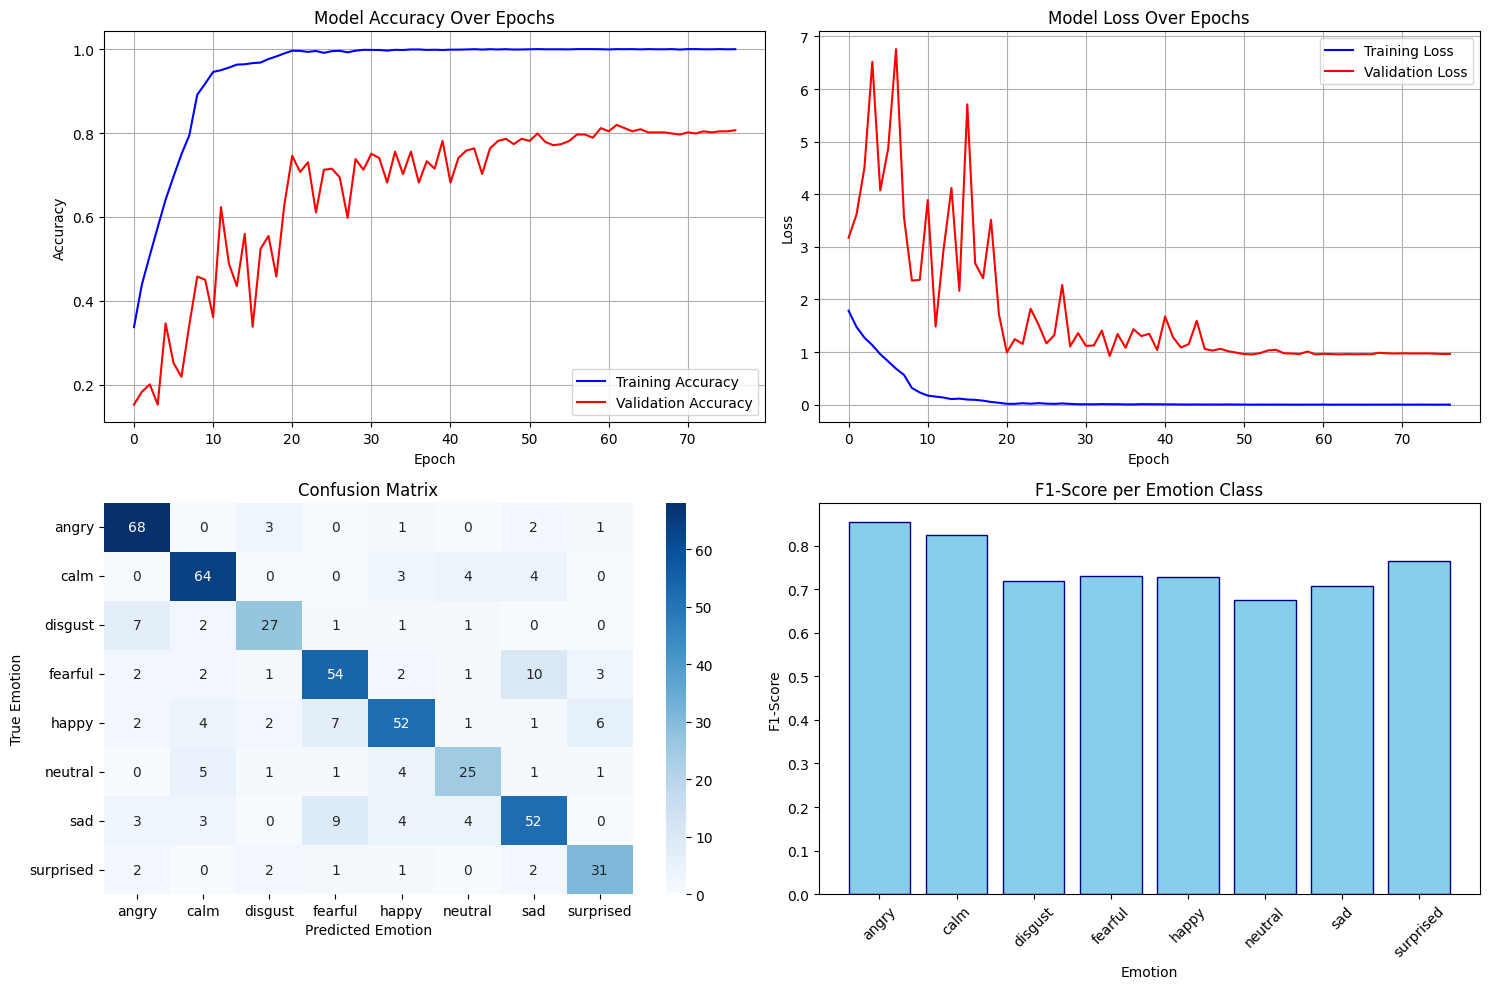


Final Training Statistics:
Total Training Epochs: 77
Best Validation Accuracy: 0.8193
Final Training Accuracy: 0.9998
Final Validation Accuracy: 0.8066
Test Set Accuracy: 0.7597
Training history saved to 'training_history.pkl'


In [15]:
# Step 17: Visualize Training Results and Performance

print("=== VISUALIZING TRAINING RESULTS ===")

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training and validation accuracy
axes[0, 0].plot(final_history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 0].plot(final_history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0, 0].set_title('Model Accuracy Over Epochs')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Training and validation loss
axes[0, 1].plot(final_history.history['loss'], label='Training Loss', color='blue')
axes[0, 1].plot(final_history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 1].set_title('Model Loss Over Epochs')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_classes, yticklabels=emotion_classes, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted Emotion')
axes[1, 0].set_ylabel('True Emotion')

# Per-class F1 Scores
axes[1, 1].bar(emotion_classes, f1, color='skyblue', edgecolor='navy')
axes[1, 1].set_title('F1-Score per Emotion Class')
axes[1, 1].set_xlabel('Emotion')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display final training statistics
print(f"\nFinal Training Statistics:")
print(f"Total Training Epochs: {len(final_history.history['accuracy'])}")
print(f"Best Validation Accuracy: {max(final_history.history['val_accuracy']):.4f}")
print(f"Final Training Accuracy: {final_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {final_history.history['val_accuracy'][-1]:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Save training history for later analysis
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(final_history.history, f)
print("Training history saved to 'training_history.pkl'")

In [16]:
# Step 18: Save Models and Components for Streamlit App

print("=== SAVING MODELS AND COMPONENTS FOR STREAMLIT APP ===")

# Save the final trained model
final_model.save('final_emotion_classification_model.h5')
print("✓ Final model saved as 'final_emotion_classification_model.h5'")

# Save the label encoder
import joblib
joblib.dump(label_encoder, 'emotion_label_encoder.pkl')
print("✓ Label encoder saved as 'emotion_label_encoder.pkl'")

# Save the normalization parameters
normalization_params = {
    'mean': float(train_mean),
    'std': float(train_std)
}

with open('normalization_params.pkl', 'wb') as f:
    pickle.dump(normalization_params, f)
print("✓ Normalization parameters saved as 'normalization_params.pkl'")

# Save the emotion mapping for reference
with open('emotion_mapping.pkl', 'wb') as f:
    pickle.dump(emotion_mapping, f)
print("✓ Emotion mapping saved as 'emotion_mapping.pkl'")

# Save model architecture summary for documentation
with open('model_architecture.txt', 'w') as f:
    final_model.summary(print_fn=lambda x: f.write(x + '\n'))
print("✓ Model architecture saved as 'model_architecture.txt'")

# Save performance metrics
performance_metrics = {
    'test_accuracy': float(test_accuracy),
    'avg_precision': float(avg_precision),
    'avg_recall': float(avg_recall),
    'avg_f1': float(avg_f1),
    'per_class_metrics': {
        emotion_classes[i]: {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1': float(f1[i]),
            'support': int(support[i])
        } for i in range(len(emotion_classes))
    },
    'confusion_matrix': cm.tolist()
}

with open('performance_metrics.pkl', 'wb') as f:
    pickle.dump(performance_metrics, f)
print("✓ Performance metrics saved as 'performance_metrics.pkl'")

print(f"\nModel Summary for Streamlit App:")
print(f"- Input Shape: (77, 174, 1) - Mel-spectrogram")
print(f"- Output Classes: {len(emotion_classes)} emotions")
print(f"- Emotion Classes: {list(emotion_classes)}")
print(f"- Test Accuracy: {test_accuracy:.2%}")
print(f"- Model Size: {final_model.count_params():,} parameters")

=== SAVING MODELS AND COMPONENTS FOR STREAMLIT APP ===
✓ Final model saved as 'final_emotion_classification_model.h5'
✓ Label encoder saved as 'emotion_label_encoder.pkl'
✓ Normalization parameters saved as 'normalization_params.pkl'
✓ Emotion mapping saved as 'emotion_mapping.pkl'


✓ Model architecture saved as 'model_architecture.txt'
✓ Performance metrics saved as 'performance_metrics.pkl'

Model Summary for Streamlit App:
- Input Shape: (77, 174, 1) - Mel-spectrogram
- Output Classes: 8 emotions
- Emotion Classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
- Test Accuracy: 75.97%
- Model Size: 355,816 parameters
